Results saved to HT_times_results.csv


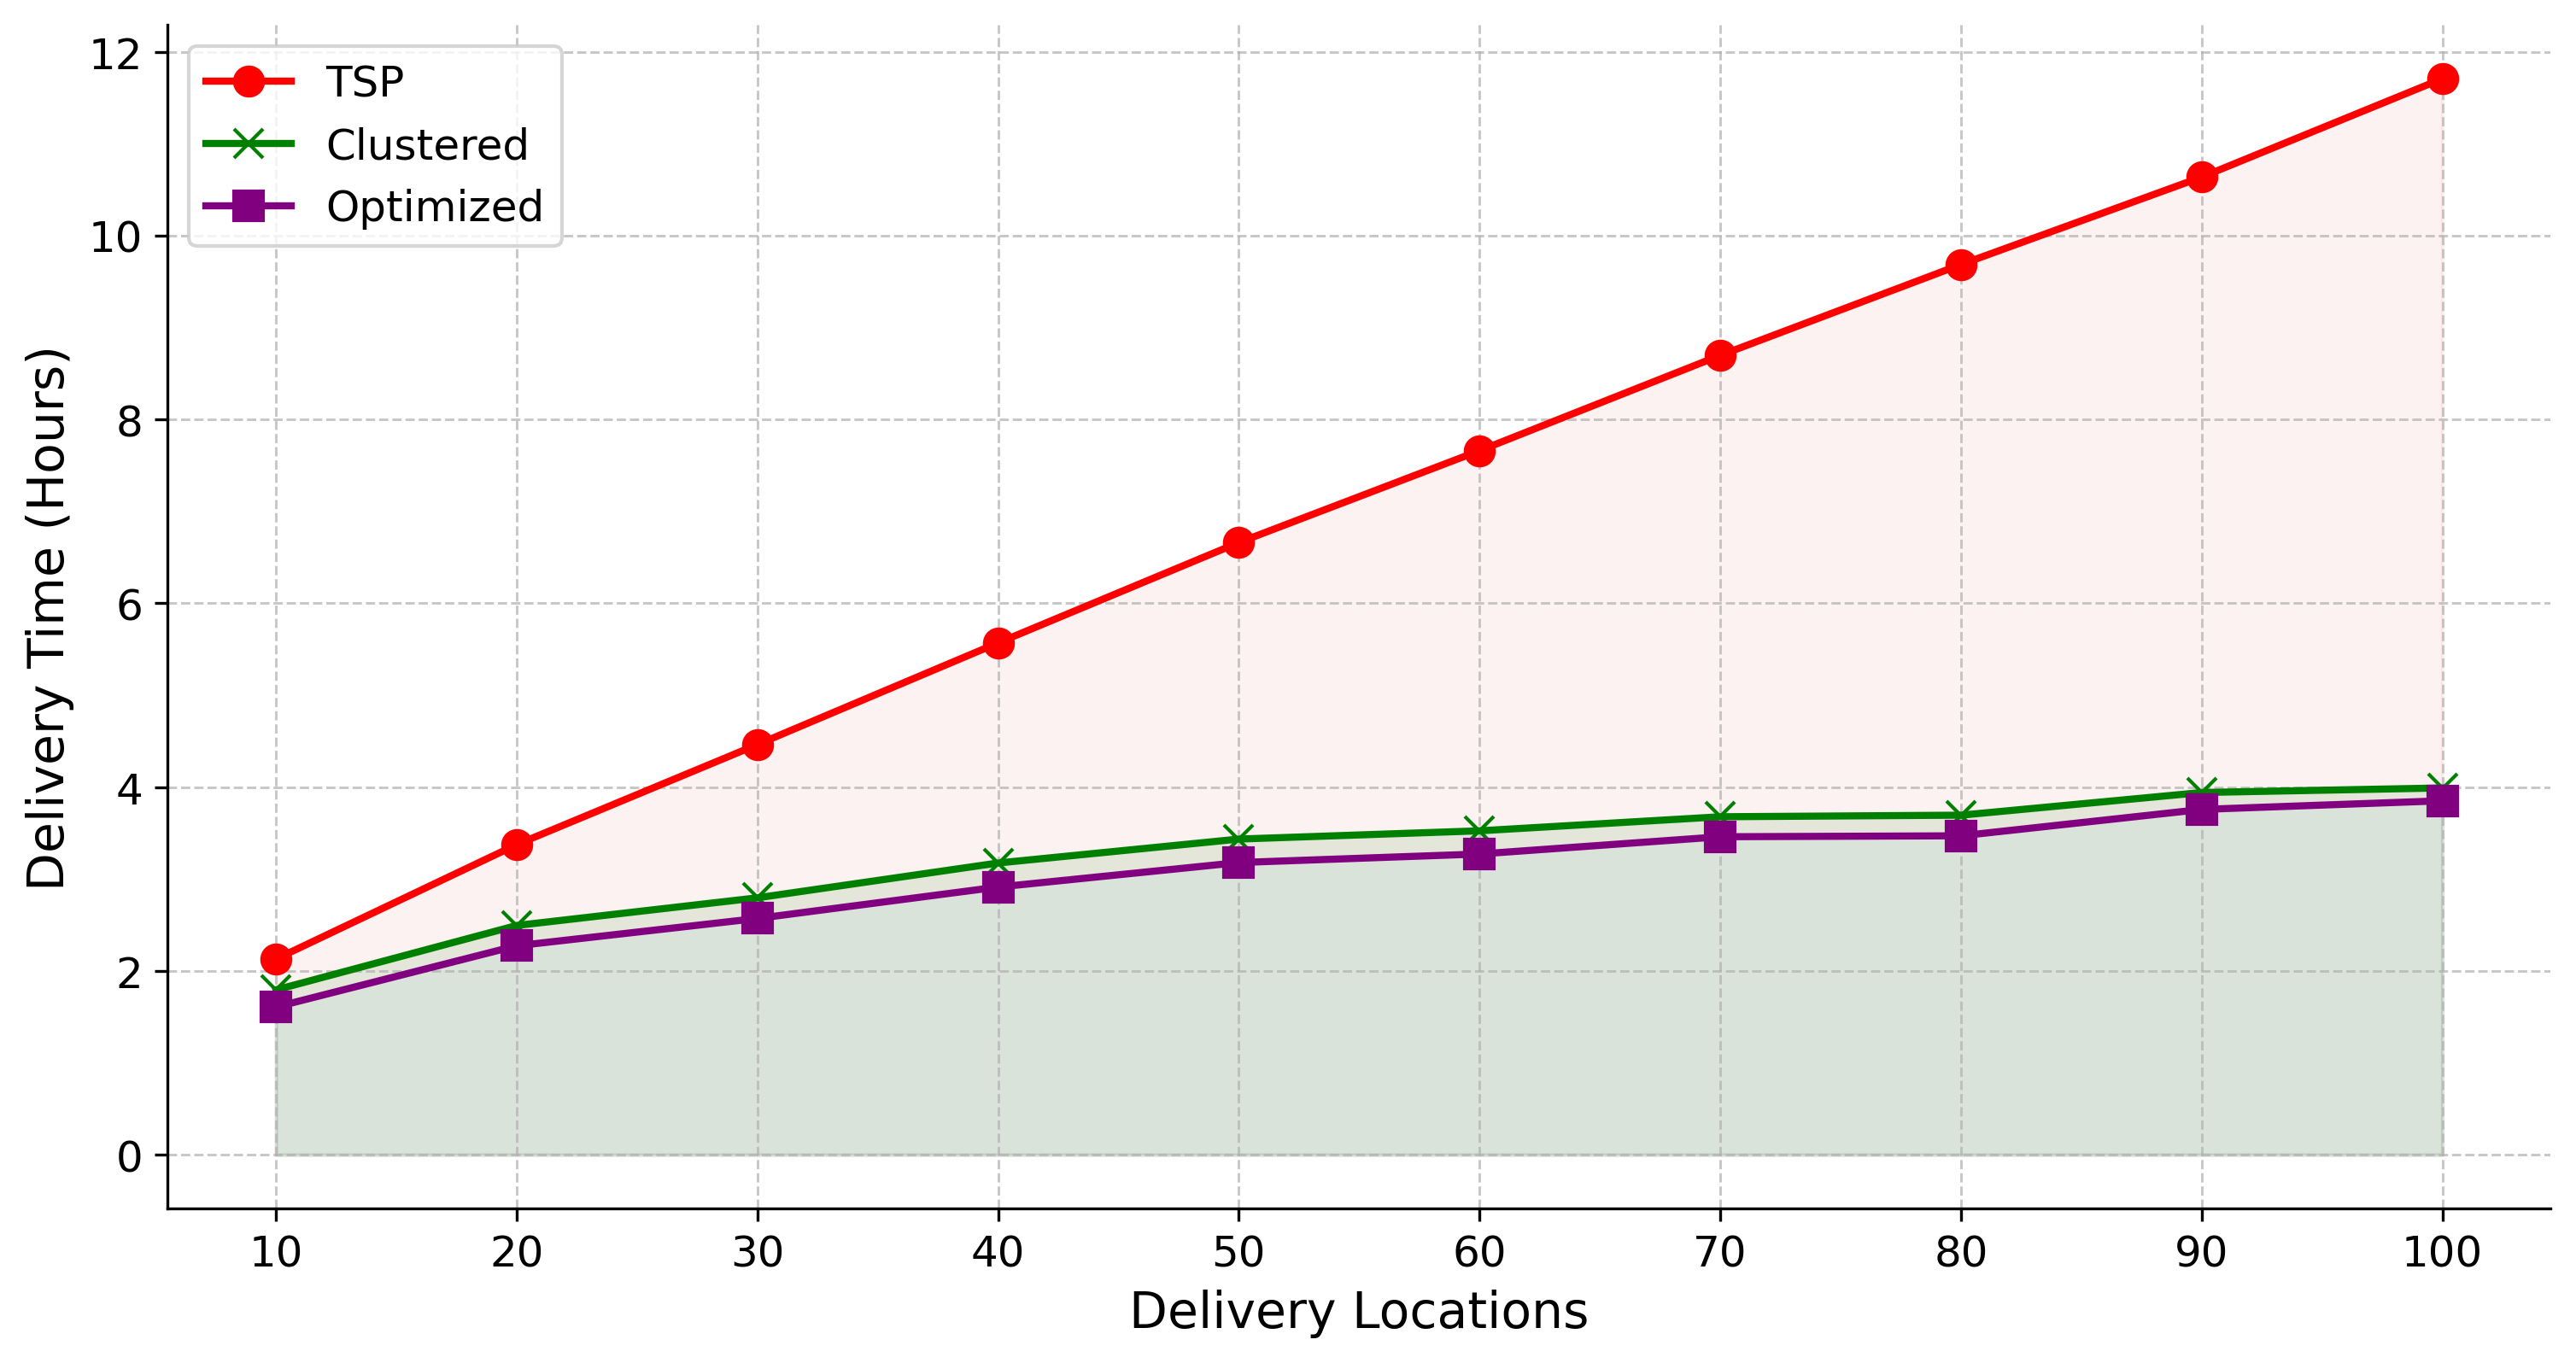

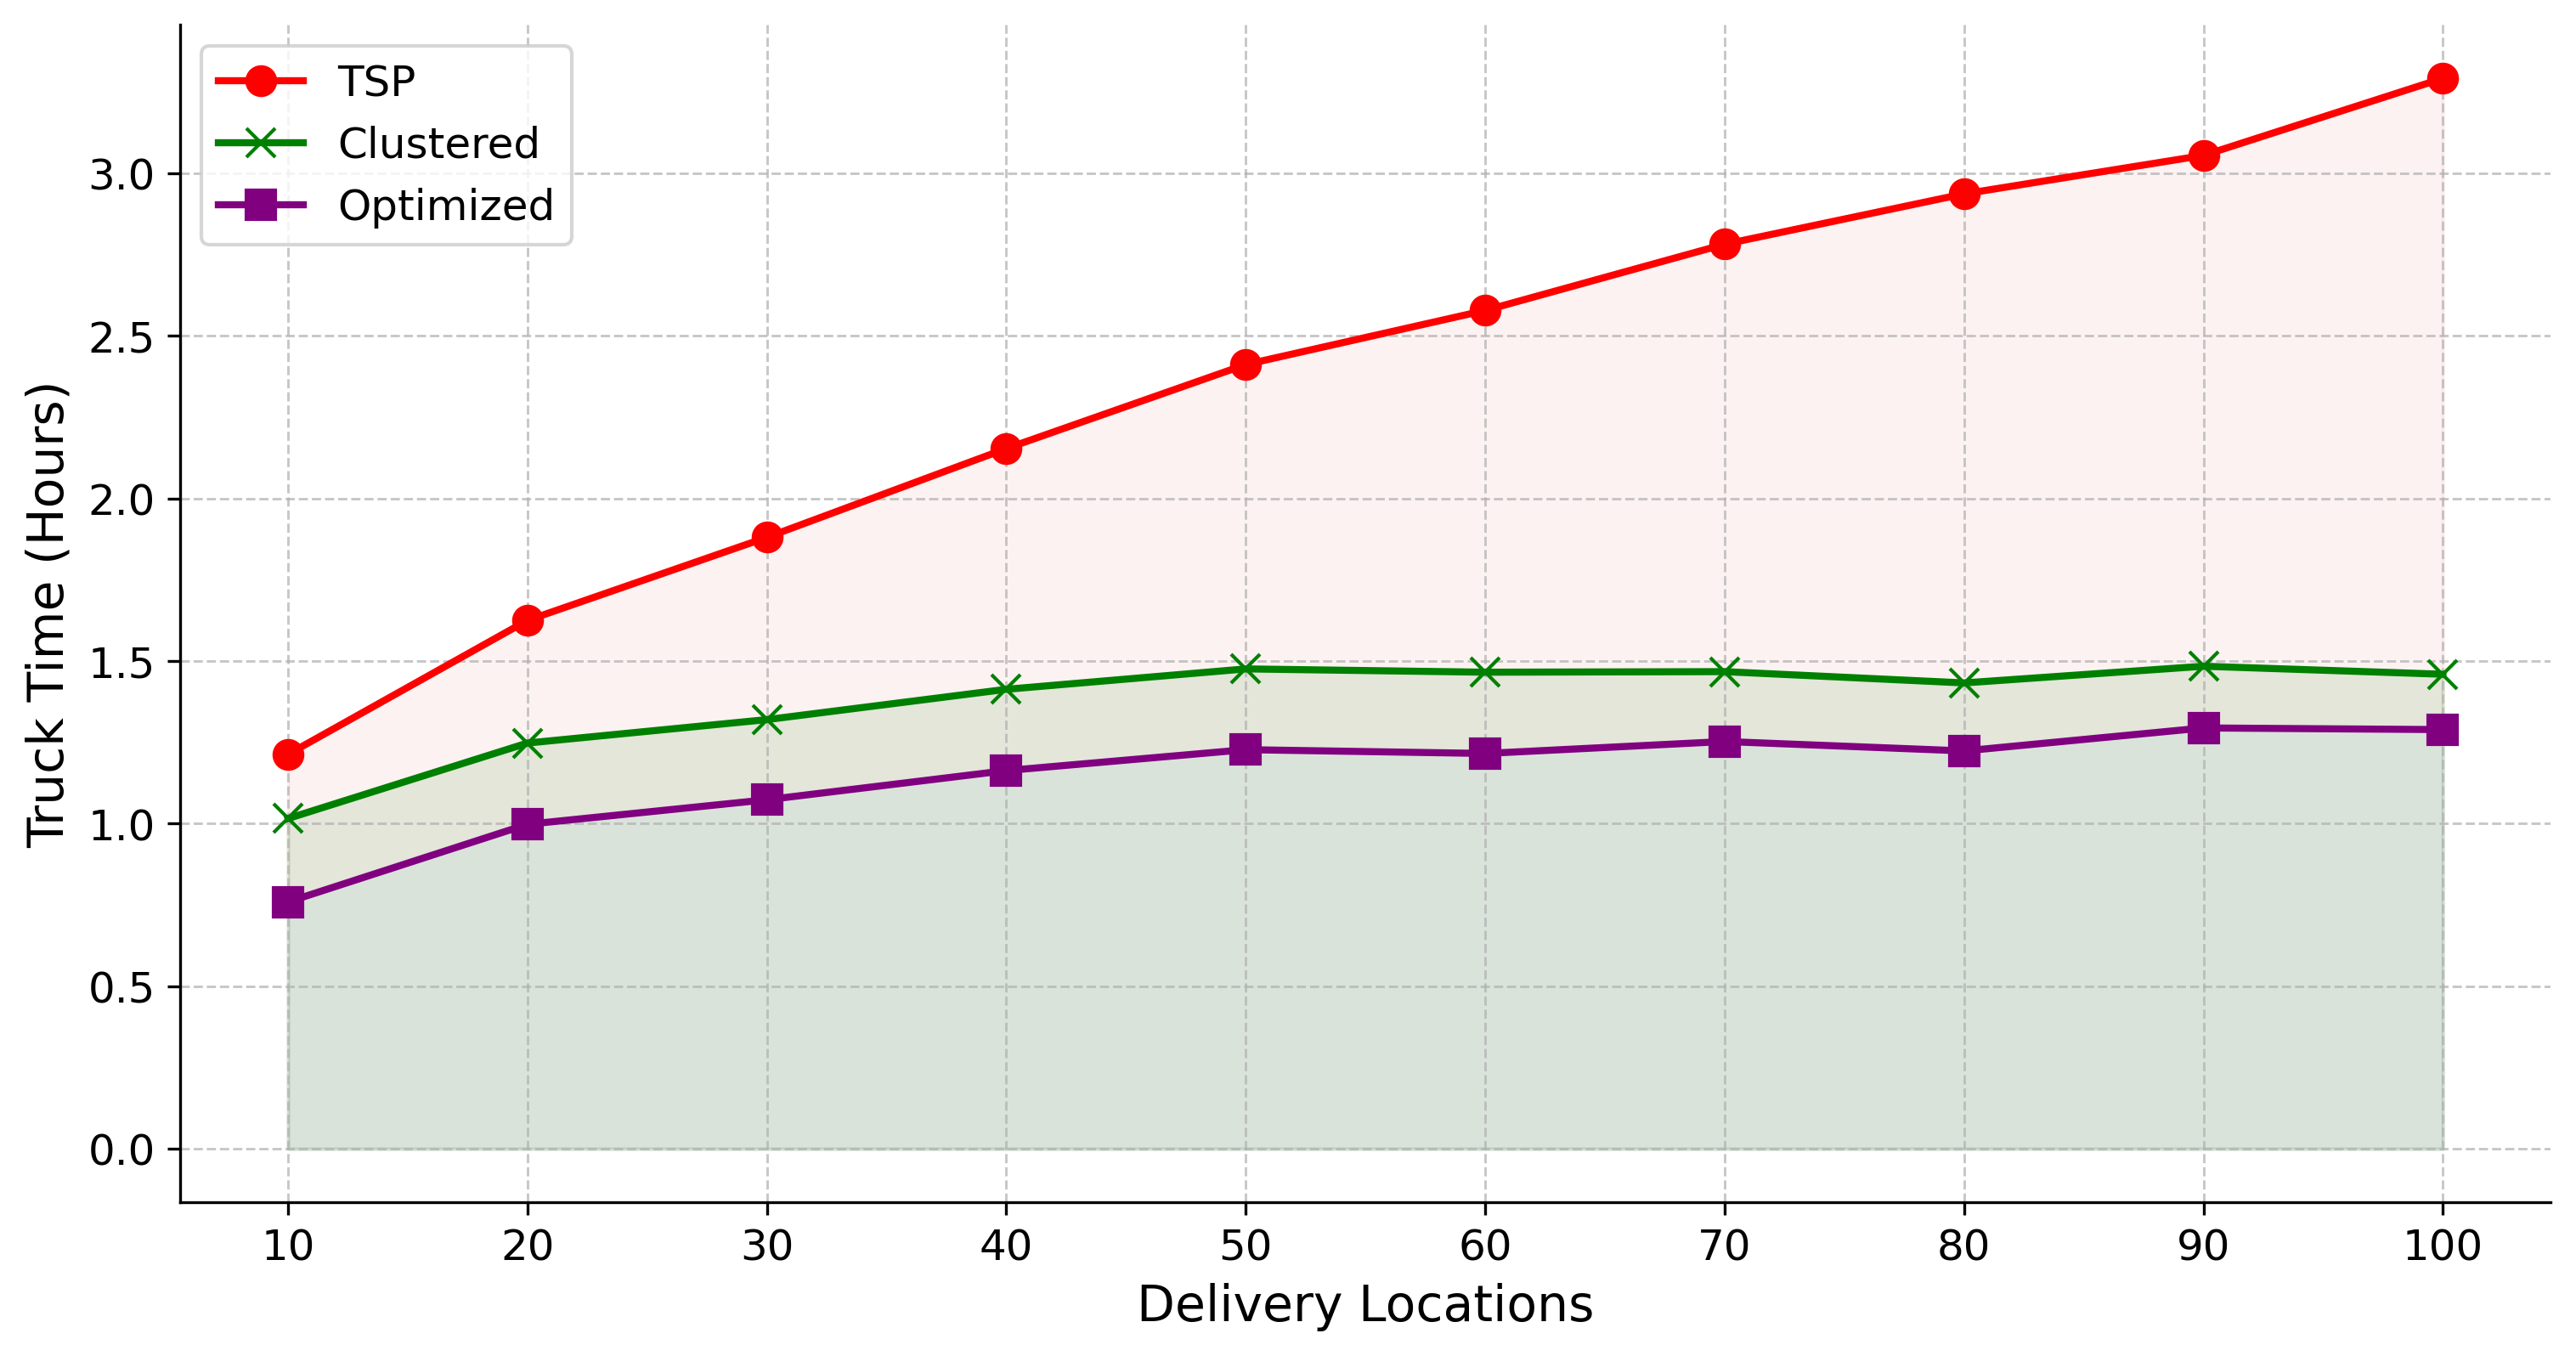

In [12]:
import os
import pandas as pd
import numpy as np  # Import NumPy to handle NaN values
from typing import List
from matplotlib import pyplot as plt

def mean_values(data: pd.DataFrame, column: str) -> float:
    """Calculate the mean value of a specified column in a DataFrame."""
    if column not in data.columns:
        raise KeyError(f"Column '{column}' not found.")
    return data[column].mean()

def load_and_check_file(file_path: str) -> pd.DataFrame:
    """Load a CSV file and perform basic checks."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    try:
        data = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        data = pd.read_csv(file_path, encoding='ISO-8859-1')

    data.columns = data.columns.str.strip()  # Clean column names
    return data

def load_and_extract_mean(file_path: str, column: str) -> float:
    """Load a CSV file and extract the mean value of a specific column."""
    data = load_and_check_file(file_path)
    return mean_values(data, column)

def replace_none_with_nan(data: List[float]) -> np.ndarray:
    """Replace None values with NaN for safe plotting."""
    return np.array([value if value is not None else np.nan for value in data])

def plot_data(delivery_locations: List[int], tsp: List[float], cluster: List[float], opt: List[float], ylabel: str, title: str) -> None:
    """Create a plot for data over different delivery locations."""
    tsp = replace_none_with_nan(tsp)
    cluster = replace_none_with_nan(cluster)
    opt = replace_none_with_nan(opt)

    plt.figure(figsize=(12, 6), dpi=300)

    # Plot the data with appropriate labels
    plt.plot(delivery_locations, tsp, label='TSP', marker='o', markersize=8, linewidth=2, color='red')
    plt.plot(delivery_locations, cluster, label='Clustered', marker='x', markersize=8, linewidth=2, color='green')
    plt.plot(delivery_locations, opt, label='Optimized', marker='s', markersize=8, linewidth=2, color='purple')

    # Fill areas under curves, ignoring NaN values
    plt.fill_between(delivery_locations, tsp, color='lightcoral', alpha=0.1, where=~np.isnan(tsp))
    plt.fill_between(delivery_locations, cluster, color='green', alpha=0.1, where=~np.isnan(cluster))
    plt.fill_between(delivery_locations, opt, color='skyblue', alpha=0.1, where=~np.isnan(opt))

    # Set labels, title, and legend
    plt.xlabel("Delivery Locations", fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(delivery_locations, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.legend(fontsize=12)

    # Remove top and right spines for a cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    #plt.tight_layout()
    plt.show()

def main():
    """Main function to load data, process it, and generate plots."""
    delivery_locations = list(range(10, 110, 10))  # Delivery locations
    file_paths = [f'Output_{location}.csv' for location in delivery_locations]

    # Column names for delivery and truck times
    delivery_columns = ['Total_delivery_times_tsp', 'Total_delivery_times_cluster', 'Total_delivery_times_optimize']
    truck_columns = ['Total_truck_times_tsp', 'Total_truck_times_cluster', 'Total_truck_times_optimize']

    # Store results in lists
    delivery_times_tsp, delivery_times_cluster, delivery_times_opt = [], [], []
    truck_times_tsp, truck_times_cluster, truck_times_opt = [], [], []

    # Loop through each file path and extract mean values
    for file in file_paths:
        try:
            # Extract delivery times
            delivery_times_tsp.append(load_and_extract_mean(file, delivery_columns[0]))
            delivery_times_cluster.append(load_and_extract_mean(file, delivery_columns[1]))
            delivery_times_opt.append(load_and_extract_mean(file, delivery_columns[2]))

            # Extract truck times
            truck_times_tsp.append(load_and_extract_mean(file, truck_columns[0]))
            truck_times_cluster.append(load_and_extract_mean(file, truck_columns[1]))
            truck_times_opt.append(load_and_extract_mean(file, truck_columns[2]))

        except (FileNotFoundError, KeyError) as e:
            print(f"Error processing {file}: {e}")
            # Append None values if there's an error
            delivery_times_tsp.append(None)
            delivery_times_cluster.append(None)
            delivery_times_opt.append(None)
            truck_times_tsp.append(None)
            truck_times_cluster.append(None)
            truck_times_opt.append(None)

    # Create DataFrame from the collected results
    df = pd.DataFrame({
        'Delivery_locations': delivery_locations,
        'Delivery_times_tsp': delivery_times_tsp,
        'Delivery_times_cluster': delivery_times_cluster,
        'Delivery_times_opt': delivery_times_opt,
        'Truck_times_tsp': truck_times_tsp,
        'Truck_times_cluster': truck_times_cluster,
        'Truck_times_opt': truck_times_opt
    })

    # Save results to CSV
    df.to_csv('HT_times_results.csv', index=False)
    print("Results saved to HT_times_results.csv")

    # Generate plots
    plot_data(
        delivery_locations, delivery_times_tsp, delivery_times_cluster, delivery_times_opt,
        ylabel="Delivery Time (Hours)", title="Comparison of Delivery Times"
    )
    plot_data(
        delivery_locations, truck_times_tsp, truck_times_cluster, truck_times_opt,
        ylabel="Truck Time (Hours)", title="Comparison of Truck Times"
    )

if __name__ == "__main__":
    main()


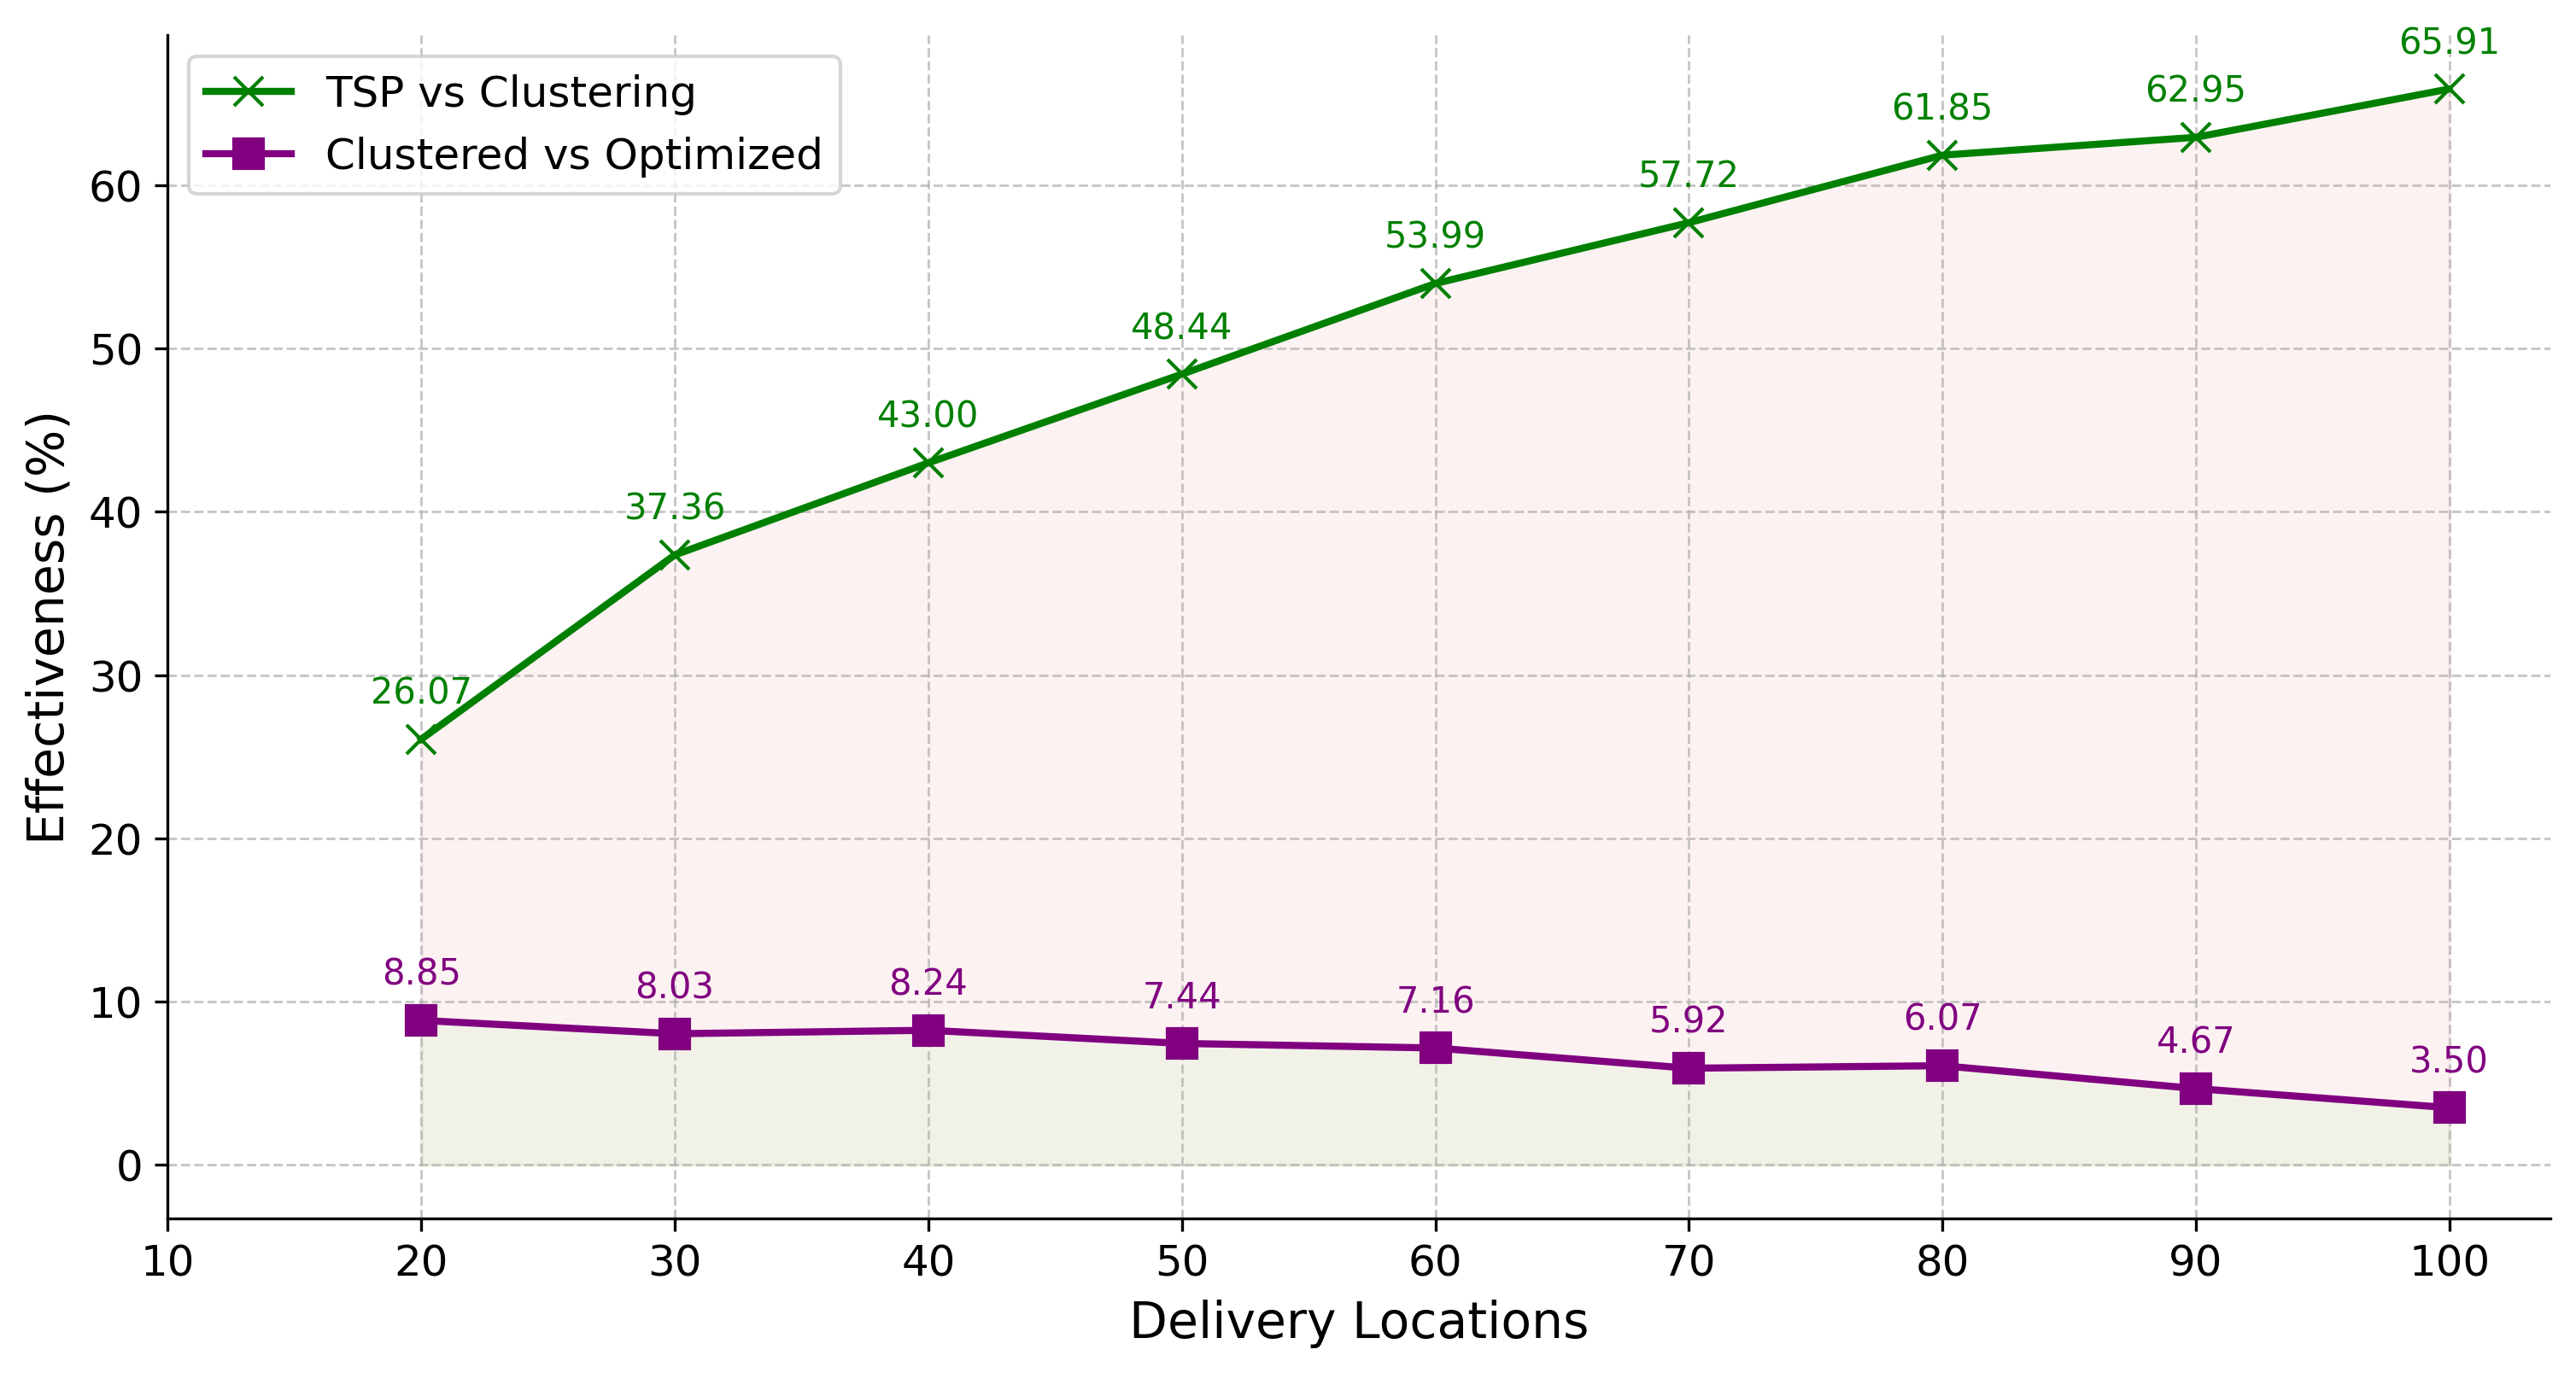

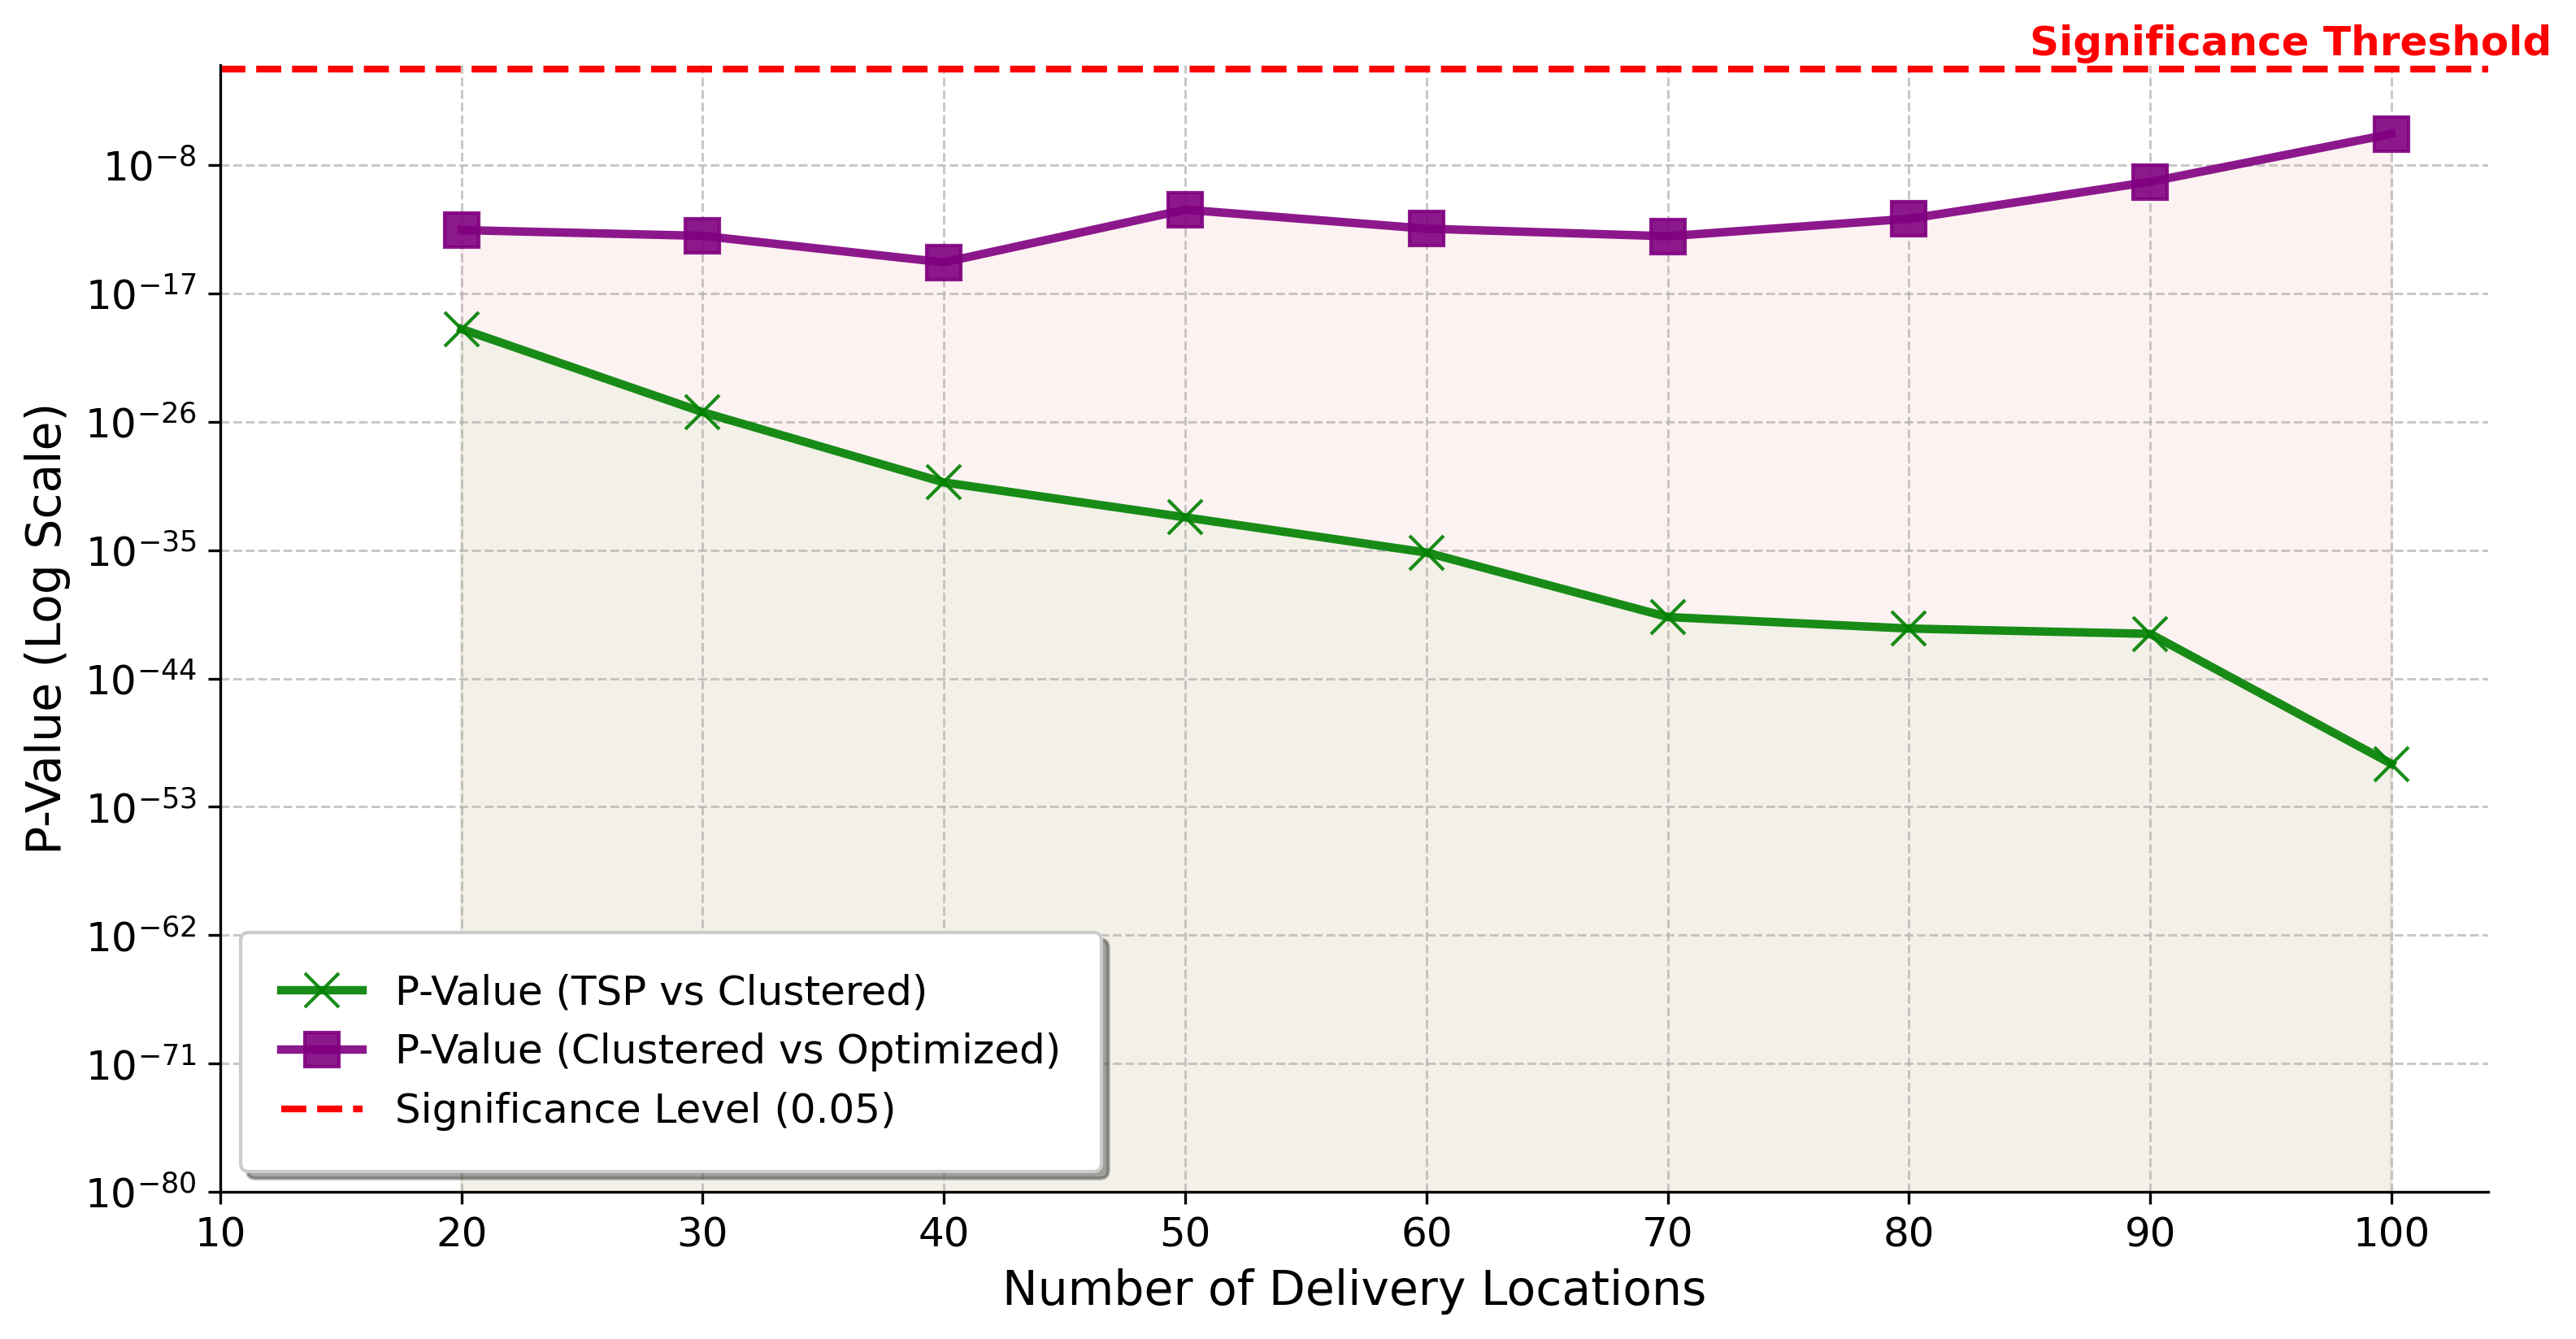

In [13]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
from typing import List
import matplotlib.pyplot as plt

def load_simulation_data(file_paths: List[str]) -> pd.DataFrame:
    """Load all simulation output files into a single DataFrame."""
    data_frames = []
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            df['Locations'] = int(file_path.split('_')[1].split('.')[0])  # Extract number of locations
            data_frames.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

    # Combine all the data into a single DataFrame
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

def perform_paired_t_tests(data: pd.DataFrame) -> pd.DataFrame:
    """Perform paired t-tests between TSP, Cluster, and Optimized times for each location set."""
    results = []

    # Group data by the number of delivery locations
    for locations, group in data.groupby('Locations'):
        tsp_times = group['Total_delivery_times_tsp']
        cluster_times = group['Total_delivery_times_cluster']
        opt_times = group['Total_delivery_times_optimize']

        # truck time 
        cluster_truck_times = group['Total_truck_times_cluster']
        opt_truck_times = group['Total_truck_times_optimize']


        # Perform paired t-tests
        t_stat_1, p_value_1 = ttest_rel(tsp_times, cluster_times)
        t_stat_2, p_value_2 = ttest_rel(cluster_times, opt_times)

        # Calculate effectiveness as the relative improvement
        effectiveness_1 = ((tsp_times.mean() - cluster_times.mean()) / tsp_times.mean()) * 100
        effectiveness_2 = ((cluster_times.mean() - opt_times.mean()) / cluster_times.mean()) * 100

        # Log results to console
        #print(f"Locations: {locations}")
        #print(f"  TSP vs Cluster: T-Statistic = {t_stat_1:.4f}, P-Value = {p_value_1:.4f}, Effectiveness = {effectiveness_1:.2f}%")
        #print(f"  Cluster vs Optimized: T-Statistic = {t_stat_2:.4f}, P-Value = {p_value_2:.4f}, Effectiveness = {effectiveness_2:.2f}%")

        # Store results
        results.append({
            'Locations': locations,
            'Tsp_avg Total_delivery_times': tsp_times.mean(),
            'Cluster_avg Total_delivery_times': cluster_times.mean(),
            'Cluster_avg Total_truck_times': cluster_truck_times.mean(),
            'T-Statistic_1': t_stat_1,
            'P-Value_1': p_value_1,
            'Effectiveness (%)_1': effectiveness_1,
            'Opt_avg Total_delivery_times': opt_times.mean(),
            'Opt_avg Total_truck_times': opt_truck_times.mean(),
            'T-Statistic_2': t_stat_2,
            'P-Value_2': p_value_2,
            'Effectiveness (%)_2': effectiveness_2
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv('paired_t_test_results.csv', index=False)
    #print("Paired t-test results saved to 'paired_t_test_results.csv'.")
    return results_df



def plot_effectiveness(results_df: pd.DataFrame) -> None:
    """Plot the effectiveness metrics for TSP vs Cluster and Cluster vs Optimized."""
    effectiveness_1 = results_df['Effectiveness (%)_1'].to_numpy()
    effectiveness_2 = results_df['Effectiveness (%)_2'].to_numpy()
    delivery_locations = results_df['Locations']

    plt.figure(figsize=(12, 6), dpi=300)
    # Plot effectiveness with markers, lines, and different colors
    plt.plot(delivery_locations, effectiveness_1, label='TSP vs Clustering', marker='x', markersize=8, linewidth=2, color='green')
    plt.plot(delivery_locations, effectiveness_2, label='Clustered vs Optimized', marker='s', markersize=8, linewidth=2, color='purple')

    # Fill areas under the curves, ignoring NaN values
    plt.fill_between(delivery_locations, effectiveness_1, color='lightcoral', alpha=0.1, where=~np.isnan(effectiveness_1))
    plt.fill_between(delivery_locations, effectiveness_2, color='lightgreen', alpha=0.1, where=~np.isnan(effectiveness_2))

    # Add values above the dots
    for i, txt in enumerate(effectiveness_1):
        plt.annotate(f'{txt:.2f}', (delivery_locations[i], effectiveness_1[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='green')
    for i, txt in enumerate(effectiveness_2):
        plt.annotate(f'{txt:.2f}', (delivery_locations[i], effectiveness_2[i]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='purple')

    # Set labels, title, and legend
    plt.xlabel("Delivery Locations", fontsize=14)
    plt.ylabel("Effectiveness (%)", fontsize=14)
    plt.xticks(delivery_locations, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.legend(fontsize=12)

    # Remove top and right spines for a cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Show the plot
    #plt.tight_layout()
    plt.show()


def plot_p_values(results_df: pd.DataFrame) -> None:
    """Create a visually appealing plot for p-values over increasing delivery locations."""
    plt.figure(figsize=(12, 6), dpi=300)

    # Plot the p-values with markers and line
    plt.plot(results_df['Locations'], results_df['P-Value_1'], label='P-Value (TSP vs Clustered)',  marker='x', markersize=10, linewidth=2.5, color='green', alpha=0.9)
    plt.plot(results_df['Locations'], results_df['P-Value_2'], label='P-Value (Clustered vs Optimized)', marker='s', markersize=10, linewidth=2.5, color='purple', alpha=0.9)

    # Fill the area under the p-values curve for better visibility
    plt.fill_between(results_df['Locations'], results_df['P-Value_1'], color='lightgreen', alpha=0.1, where=~np.isnan(results_df['P-Value_1']))
    plt.fill_between(results_df['Locations'], results_df['P-Value_2'], color='lightcoral', alpha=0.1, where=~np.isnan(results_df['P-Value_2']))

    # Add a significance level line at 0.05
    plt.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Significance Level (0.05)')
    plt.text(x=results_df['Locations'].max() - 15, y=0.5, s="Significance Threshold", color='red', fontsize=12, weight='bold')

    # Set logarithmic y-axis scale for better visualization
    plt.yscale('log')
    plt.ylim(bottom=1e-80, top=0.1)  # Set appropriate limits for better readability

    # Set labels, title, and legend
    plt.xlabel("Number of Delivery Locations", fontsize=14)
    plt.ylabel("P-Value (Log Scale)", fontsize=14)
    plt.xticks(results_df['Locations'], fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Enhance legend with shadow and frame
    plt.legend(fontsize=12, loc='lower left', frameon=True, fancybox=True, shadow=True, borderpad=1)

    # Remove unnecessary spines for a cleaner look
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Show the plot
    #plt.tight_layout()
    plt.show()

def main():
    """Main function to load data, perform t-tests, and plot results."""
    # Define the file paths
    delivery_locations = list(range(10, 110, 10))  # Delivery locations from 10 to 60
    file_paths = [f'Output_{loc}.csv' for loc in delivery_locations]

    # Load the simulation data
    data = load_simulation_data(file_paths)

    # Perform paired t-tests and get results DataFrame
    results_df = perform_paired_t_tests(data)

    # Plot effectiveness comparison
    plot_effectiveness(results_df)
    plot_p_values(results_df)

if __name__ == "__main__":
    main()
